In [1]:
using Revise, Pkg
Pkg.activate("/home/louise/MSA/BpAlignGpu.jl")
using BpAlignGpu

  Activating project at `~/MSA/BpAlignGpu.jl`


In [2]:
using CUDA
CUDA.device!(1)

┌ Warning: The NVIDIA driver on this system only supports up to CUDA 11.0.0.
│ For performance reasons, it is recommended to upgrade to a driver that supports CUDA 11.2 or higher.
└ @ CUDA /home/louise/.julia/packages/CUDA/Uurn4/src/initialization.jl:70


CuDevice(1): TITAN RTX

In [3]:
T = Float32
q = 21
ctype=Symbol("amino")
typel=Symbol("bm")
muext = 0.00
muint = 2.50;

# -------------- Choose family --------------

In [4]:
#open("/home/louise/MSA/Data/test/PF00684/")
#L = 67; 

#J, H = BpAlignGpu.read_parameters("/home/louise/MSA/Data/test/PF00684/Parameters_bm_PF00684seed_potts.dat", q, L, gap=0, typel=typel);

#delta = 50;
#al = BpAlignGpu.enveloptoalign( "/home/louise/MSA/Data/test/PF00684/Test_PF00684.full", "/home/louise/MSA/Data/test/PF00684/Test_PF00684.fasta", "/home/louise/MSA/Data/test/PF00684/Test_PF00684.ins", delta = delta, ctype = ctype);
#M = length(al)

#using DelimitedFiles
#Lambda_all = readdlm("/home/louise/MSA/Data/test/PF00684/Lambda_PF00684.dat")
#lambda_o = Lambda_all[:,1];
#lambda_e = Lambda_all[:,2];


In [5]:
open("/home/louise/MSA/Data/test/PF00397/")
L = 31; 

J, H = BpAlignGpu.read_parameters("/home/louise/MSA/Data/test/PF00397/Parameters_plm_PF00397.dat", q, L, gap=0, typel=typel);

delta = 5;
al = BpAlignGpu.enveloptoalign( "/home/louise/MSA/Data/test/PF00397/PF00397_full_length_sequences.fasta", "/home/louise/MSA/Data/test/PF00397/PF00397_full.fasta", "/home/louise/MSA/Data/test/PF00397/PF00397_full.inse", delta = delta, ctype = ctype);
M = length(al)

using DelimitedFiles
Lambda_all = readdlm("/home/louise/MSA/Data/test/PF00397/Lambda_PF00397.dat")
lambda_o = Lambda_all[1,:];
lambda_e = Lambda_all[2,:];


┌ Info: Assuming J i j a b and h i a format
└ @ BpAlignGpu /home/louise/MSA/BpAlignGpu.jl/src/utils.jl:37
┌ Info: Output tersors: J[a b i j] and h[a i]
└ @ BpAlignGpu /home/louise/MSA/BpAlignGpu.jl/src/utils.jl:39
┌ Info: Gap in input file 0 now in 21
└ @ BpAlignGpu /home/louise/MSA/BpAlignGpu.jl/src/utils.jl:40


In [6]:
##Random Data
#(N, L) = (6, 5) 
##(N, L) = (161, 67)

#lambda_o = ones(L)
#lambda_e = ones(L)
#H = rand(q,L)
#J = rand(q,q,L,L)
#J = J .+ permutedims(J, (2,1,4,3));

# -------------- Function to find Ground State --------------

In [7]:
using Statistics
using Plots

In [8]:
include("../src/functionsforanalysis.jl")

EpsilonScan (generic function with 1 method)

# -------------- Loop over sequences --------------

In [9]:
using DelimitedFiles
fam = readdlm("PF00397_sols.txt");
samples = fam[:,1];

In [10]:
(Nmin, Nmax) = extrema([length(al[idx0][2]) for idx0 in 1:M])
ibig = findall([length(al[idx0][2]) for idx0 in 1:M] .== Nmax)[1]
ismall = findall([length(al[idx0][2]) for idx0 in 1:M] .== Nmin)[1];

In [11]:
#build paramalgo
damp=T(0.9)
tol=T(1e-3)
tolnorm=T(1e-10)
tmax=10
upscheme=:random 
initcond=:random 
lr=:sce  
beta=T(0.0)
verbose=false
xnsol = fill((0, 0), L);
epscoupling=(false, T(0.0), xnsol)
pa = ParamAlgo(damp, tol, tolnorm, tmax, upscheme, initcond, lr, beta, verbose, epscoupling)

ParamAlgo{Float32}
-------------
damp=0.9
tol=0.001
tolnorm=1.0e-10
tmax=10
upscheme=random
initcond=random
lr=sce
beta=0.0
verbose=false
epscoupling=false
-------------

In [12]:
betas_seq = []
errs_seq = []
polars_seq = []
ens_seq = []

rangesamp = 1:101

xnsols_seq = fill(fill((0, 0), L), eachindex(rangesamp))
bels_seq = ones(Nmax+2,2,L, length(rangesamp));

In [79]:
for (i,idx0) in pairs(samples[rangesamp])
    seq = BpAlignGpu.Seq(al[idx0][3], al[idx0][2], ctype)
    N = length(al[idx0][2])
    @show i, idx0, N
end



(i, idx0, N) = (1, 46958, 40)
(i, idx0, N) = (2, 29277, 40)


In [ ]:
for (i,idx0) in pairs(samples[rangesamp])
    @show i, idx0

    #build seq, pm
    seq = BpAlignGpu.Seq(al[idx0][3], al[idx0][2], ctype)
    N = length(al[idx0][2])
    pm = ParamModel{T}(N, L, q, muint, muext, lambda_o, lambda_e, H, J)
    
    @show seq
    #build BP fields
    bpm = BPMessages(seq, pm, pa)
    bpb = BPBeliefs(N, L)
    lrf = LongRangeFields(N, L)
    af = AllFields(bpm, bpb, lrf)
    
    #find ground state
    betas, errs, polars, ens = findGS(af, pm, pa, seq, iters = 2000, minpol = 0.95, nmax = 100, minbet = 0.005)    

    #store betas, convergence errors, energies and minimum polarizations
    append!(betas_seq, [betas])
    append!(errs_seq, [errs])
    append!(polars_seq, [polars])
    append!(ens_seq, [ens])
    
    #compute solution:
    xnsol, maxbel = BpAlignGpu.solmaxbel(af)
    xnsols_seq[i] = xnsol
    bel = Array(af.bpb.beliefs)
    bels_seq[1:N+2,:,:,i] = bel
    
    println("\n")
end



(i, idx0) = (1, 46958)
seq = LPEGWEMRFTVD-GIPYFVDHNRRTTTYIDP
LNEKPLPEGWEMRFTVDGIPYFVDHNRRTTTYIDPRTGKS
beta = 0.0
converged: err=0.0009934679, tol=0.001, nbiter=62
(polar, energy) = (0.03936131f0, 36.924572f0)
beta = 0.1
converged: err=0.0009689629, tol=0.001, nbiter=41
(polar, energy) = (0.052023116f0, 54.887794f0)
beta = 0.2
converged: err=0.0009824932, tol=0.001, nbiter=44
(polar, energy) = (0.07369357f0, 13.519539f0)
beta = 0.30000000000000004
converged: err=0.00098975, tol=0.001, nbiter=99
(polar, energy) = (0.14342327f0, -30.776302f0)
beta = 0.4
converged: err=0.0009844303, tol=0.001, nbiter=232
(polar, energy) = (0.7893517f0, -56.71604f0)
beta = 0.5
converged: err=0.0009775758, tol=0.001, nbiter=106
(polar, energy) = (0.9228755f0, -56.71604f0)
beta = 0.6
converged: err=0.00093722343, tol=0.001, nbiter=98
(polar, energy) = (0.9685458f0, -56.71604f0)


(i, idx0) = (2, 29277)
seq = LPPGWEERTHTD-GRIFYINHNIKRTQWEDP
SDLGPLPPGWEERTHTDGRIFYINHNIKRTQWEDPRLQNV
beta = 0.0
converged: err=0.0

converged: err=0.0009954572, tol=0.001, nbiter=125
(polar, energy) = (0.9299173f0, -58.57665f0)
beta = 0.6
converged: err=0.0009750128, tol=0.001, nbiter=133
(polar, energy) = (0.9700595f0, -58.57665f0)


(i, idx0) = (10, 35008)
seq = --PVWETHTDAGTGRLYYYNPDTGVTTWESP
AAPGPSPVWETHTDAGTGRLYYYNPDTGVTTWESPFEAAE
beta = 0.0
converged: err=0.0009967536, tol=0.001, nbiter=58
(polar, energy) = (0.03856916f0, 33.943474f0)
beta = 0.1
converged: err=0.0009802878, tol=0.001, nbiter=41
(polar, energy) = (0.05108192f0, 35.159023f0)
beta = 0.2
converged: err=0.0009688437, tol=0.001, nbiter=46
(polar, energy) = (0.07238549f0, 14.514706f0)
beta = 0.30000000000000004
converged: err=0.0009960979, tol=0.001, nbiter=146
(polar, energy) = (0.17160496f0, -31.09574f0)
beta = 0.4
converged: err=0.0009998083, tol=0.001, nbiter=244
(polar, energy) = (0.6613745f0, -45.70562f0)
beta = 0.5
converged: err=0.0009896159, tol=0.001, nbiter=88
(polar, energy) = (0.82103854f0, -45.70562f0)
beta = 0.6
converged: err=0.00096

In [ ]:
[[ens_seq[j][end] for j in eachindex(samples[rangesamp])]]

In [ ]:
pb = scatter(rangesamp, [[betas_seq[j][end] for j in eachindex(samples[rangesamp])]], label="beta")
per = scatter(rangesamp, [[errs_seq[j][end] for j in eachindex(samples[rangesamp])]], label="error")
pp = scatter(rangesamp, [[polars_seq[j][end] for j in eachindex(samples[rangesamp])]], label = "polarization")
hline!([0.95], label="min for polarization")
pen = scatter(rangesamp, [[ens_seq[j][end] for j in eachindex(samples[rangesamp])]], label="energy")
p = plot(pb, per, pp, pen)

In [ ]:
j=1
perr = scatter(betas_seq[j], errs_seq[j], label="err")
hline!([pa.tol], label="tol")
ppol = scatter(betas_seq[j], polars_seq[j], label="polarization")
hline!([0.95], label="min for polarization")
pen = scatter(betas_seq[j], ens_seq[j], label="energy")
p = plot(perr, ppol, pen, size=(800,400))

In [ ]:
using Plots
j=1
N = length(al[samples[j]][2])
bel = bels_seq[1:N+2,:,:,j];
p0 = heatmap(bel[:,1,:], xlabel="i", ylabel="n", title="x=0")
p1 = heatmap(bel[:,2,:], xlabel="i", ylabel="n", title="x=1")
p = plot(p0, p1, size=(500,250))

In [ ]:
rangesamp

In [ ]:
matches = []
checks = []
entots_sce = []
entots_dca = []
entots_hhmer = []

for (i,j) in pairs(rangesamp)
    idx0 = samples[j]
    seq = BpAlignGpu.Seq(al[idx0][3], al[idx0][2], ctype)
    N = length(al[idx0][2])
    pm = ParamModel{T}(N, L, q, muint, muext, lambda_o, lambda_e, H, J)    
    
    seqsol = BpAlignGpu.convert_soltosequence!(xnsols_seq[i], seq.strseq, N, L)
    check = BpAlignGpu.check_sr!(xnsols_seq[i], L, N)
    append!(checks, sum(check)) 
    solDCA = (fam[j,2:5]...,)
    append!(matches, seqsol == solDCA)
    ensce = BpAlignGpu.compute_cost_function(pm.J, pm.H, seqsol[2], L, ctype, pm.lambda_o, pm.lambda_e, pm.muext, pm.muint)
    append!(entots_sce, ensce) 
    endca = BpAlignGpu.compute_cost_function(pm.J, pm.H, String(solDCA[2]), L, ctype, pm.lambda_o, pm.lambda_e, pm.muext, pm.muint)
    append!(entots_dca, endca) 
    enhhm = BpAlignGpu.compute_cost_function(pm.J, pm.H, al[idx0][4], L, ctype, pm.lambda_o, pm.lambda_e, pm.muext, pm.muint)
    append!(entots_hhmer, enhhm) 
end

In [ ]:
nnotsol = length(findall(checks .> 0))
@show nnotsol
findall(checks .> 0)

In [ ]:
ndiffscedca = length(findall(matches .== false))
@show ndiffscedca
findall(matches .== false)

In [ ]:
n_sce_worse_dca = length(findall(entots_sce .- entots_dca .> 0.0))
n_sce_better_dca =length(findall(entots_sce .- entots_dca .< 0.0))
@show n_sce_worse_dca, n_sce_better_dca
findall(entots_sce .- entots_dca .> 0.0)

In [ ]:
n_sce_worse_hhmer = length(findall(entots_sce .- entots_hhmer .> 0.0))
n_sce_better_hhmer = length(findall(entots_sce .- entots_hhmer .< 0.0))
@show n_sce_worse_hhmer, n_sce_better_hhmer
findall(entots_sce .- entots_hhmer .> 0.0)

In [ ]:
n_dca_worse_hhmer = length(findall(entots_dca .- entots_hhmer .> 0.0))
n_dca_better_hhmer = length(findall(entots_dca .- entots_hhmer .< 0.0))
@show n_dca_worse_hhmer, n_dca_better_hhmer

In [ ]:
xnsols_seq

# -------------- $\epsilon$ increasing --------------

# look at one $\epsilon$

In [91]:
@show xnsols_seq[1] == xnsol

xnsols_seq[1] == xnsol = true


true

In [92]:
ind = 4
idx0 = samples[4]
@show idx0
seq = BpAlignGpu.Seq(al[idx0][3], al[idx0][2], ctype)
N = length(al[idx0][2])
pm = ParamModel{T}(N, L, q, muint, muext, lambda_o, lambda_e, H, J)

idx0 = 47888


ParamModel{Float32}[L=31 N=40 q=21 size=1.619 MiB]

In [93]:
ϵ = -1.0
pa.beta = 0.0
pa.verbose = false
pa.epscoupling = (true, ϵ, xnsols_seq[1])
pa

ParamAlgo{Float32}
-------------
damp=0.9
tol=0.001
tolnorm=1.0e-10
tmax=10
upscheme=random
initcond=random
lr=sce
beta=0.0
verbose=false
epscoupling=true, ϵ=-1.0
-------------

In [94]:
seq, idx0, ind


(LPEGWEKRIDPN-GRVYFVNHKNKTTQWEDP
DPLGPLPEGWEKRIDPNGRVYFVNHKNKTTQWEDPRTQGK, 47888, 4)

In [95]:
bpm = BPMessages(seq, pm, pa)
bpb = BPBeliefs(N, L)
lrf = LongRangeFields(N, L)
af = AllFields(bpm, bpb, lrf)

AllFields{Float32}[L=31 N=40 ongpu=true size=53.492 MiB]

In [96]:
#find ground state
betas_ϵ, errs_ϵ, polars_ϵ, ens_ϵ, xnsol_ϵ, bel_ϵ = findGS(af, pm, pa, seq, iters = 2000, minpol = 0.95, nmax = 100, minbet = 0.01)    


beta = 0.0
converged: err=0.0009968355, tol=0.001, nbiter=57
(polar, energy) = (0.038623046f0, 30.48547f0)
beta = 0.1
converged: err=0.0009994209, tol=0.001, nbiter=40
(polar, energy) = (0.051195942f0, 40.086266f0)
beta = 0.2
converged: err=0.000978142, tol=0.001, nbiter=45
(polar, energy) = (0.070182934f0, 41.388763f0)
beta = 0.30000000000000004
converged: err=0.0009838939, tol=0.001, nbiter=46
(polar, energy) = (0.09604795f0, 33.865997f0)
beta = 0.4
converged: err=0.0009913743, tol=0.001, nbiter=47
(polar, energy) = (0.1291402f0, 25.199108f0)
beta = 0.5
(polar, energy) = (0.70517683f0, -38.929493f0)
beta = 0.6
(polar, energy) = (0.70246696f0, -29.554482f0)
decrease incbet: 0.05 ** polar_old: 0.70517683, polar: 0.70246696 ** energy_old: -38.929493, energy: -29.554482
beta = 0.55
(polar, energy) = (0.78040266f0, -64.54838f0)
beta = 0.6000000000000001
(polar, energy) = (0.8482329f0, -64.54838f0)
beta = 0.6500000000000001
(polar, energy) = (0.79265875f0, -48.595364f0)
decrease incbet: 0.

(Any[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.55, 0.6000000000000001, 0.6125, 0.625], Any[0.0009968355f0, 0.0009994209f0, 0.000978142f0, 0.0009838939f0, 0.0009913743f0, 0.546193f0, 0.6638906f0, 0.7716117f0, 0.7471992f0, 0.70718014f0], Any[0.038623046f0, 0.051195942f0, 0.070182934f0, 0.09604795f0, 0.1291402f0, 0.70517683f0, 0.78040266f0, 0.8482329f0, 0.8648736f0, 0.86756265f0], Any[30.48547f0, 40.086266f0, 41.388763f0, 33.865997f0, 25.199108f0, -38.929493f0, -64.54838f0, -64.54838f0, -64.54838f0, -64.54838f0], [(1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15)  …  (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35)], [0.04405811 0.0; 0.0 0.0007481861; … ; 0.0 3.255076f-11; 0.0 0.0;;; 0.005519892 0.0; 3.6184517f-6 3.98943f-5; … ; 0.0 7.816644f-11; 1.1162491f-9 0.0;;; 0.0018675306 0.0; 9.574337f-7 6.560689f-6; … ; 0.0 8.837901f-11; 2.6036064f-9 0.0;;; … ;;; 1.4433638f-9 0.0; 8.359484f-12 4.6493136f-11; … ; 0.0 

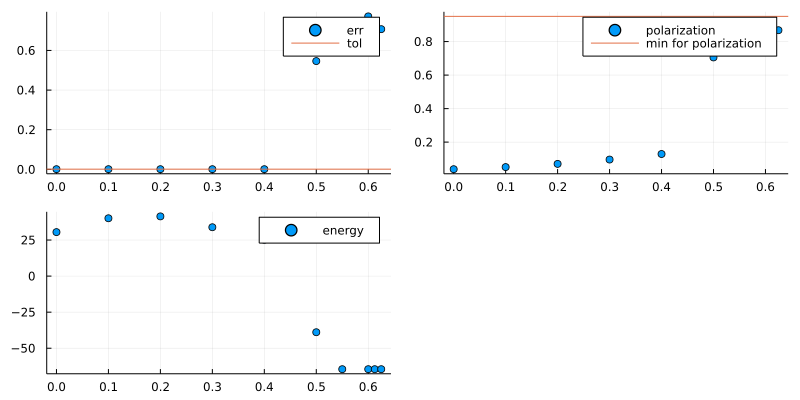

In [97]:
betas_ϵ, errs_ϵ, polars_ϵ, ens_ϵ
perr = scatter(betas_ϵ, errs_ϵ, label="err")
hline!([pa.tol], label="tol")
ppol = scatter(betas_ϵ, polars_ϵ, label="polarization")
hline!([0.95], label="min for polarization")
pen = scatter(betas_ϵ, ens_ϵ, label="energy")
p = plot(perr, ppol, pen, size=(800,400))


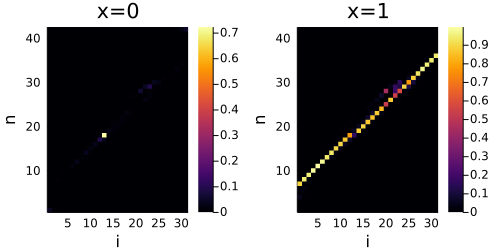

In [101]:
p0 = heatmap(bel_ϵ[:,1,:], xlabel="i", ylabel="n", title="x=0")
p1 = heatmap(bel_ϵ[:,2,:], xlabel="i", ylabel="n", title="x=1")
p = plot(p0, p1, size=(500,250))


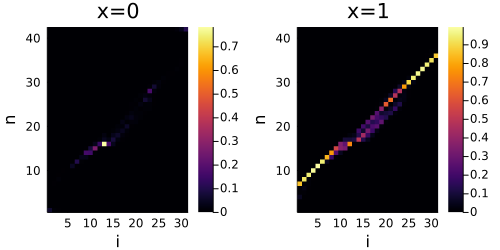

In [102]:
bel = Array(af.bpb.beliefs)
p0 = heatmap(bel[:,1,:], xlabel="i", ylabel="n", title="x=0")
p1 = heatmap(bel[:,2,:], xlabel="i", ylabel="n", title="x=1")
p = plot(p0, p1, size=(500,250))


In [103]:
xnsol_afϵ, maxbel_afϵ = BpAlignGpu.solmaxbel(af)

@show 
seqsol_afϵ = BpAlignGpu.convert_soltosequence!(xnsol_afϵ, seq.strseq, N, L)
check_afϵ = BpAlignGpu.check_sr!(xnsol_afϵ, L, N)
energy_afϵ = BpAlignGpu.compute_cost_function(pm.J, pm.H, seqsol_afϵ[2], pm.L, ctype, pm.lambda_o, pm.lambda_e, pm.muext, pm.muint)


-29.554482f0

In [104]:
ens_ϵ[end]

-64.54838f0

# ---------- Scan ----------

In [ ]:
#build paramalgo
damp=T(0.9)
tol=T(1e-3)
tolnorm=T(1e-10)
tmax=10
upscheme=:random 
initcond=:random 
lr=:sce  
beta=T(0.0)
verbose=false
xnsol = fill((0, 0), L);
epscoupling=(false, T(0.0), xnsol)
pa = ParamAlgo(damp, tol, tolnorm, tmax, upscheme, initcond, lr, beta, verbose, epscoupling)

In [ ]:
#epsilons = [-0.001, -0.1, -0.5, -1.0, -5.0, -10.0, -50.0, -100.0, -500.0, -1000];
#epsilons = [-5.0, -10.0, -50.0, -100.0, -500.0, -1000];

epsilons = -0.5:-0.5:-3.5

In [ ]:
betas_seq_eps = []
errs_seq_eps = []
polars_seq_eps = []
ens_seq_eps = []

xnsols_seq_eps = []
bels_seq_eps = ones(Nmax+2,2,L, eachindex(epsilons), length(rangesamp));

In [ ]:
for (i,idx0) in pairs(samples[rangesamp])

    #build seq, pm
    seq = BpAlignGpu.Seq(al[idx0][3], al[idx0][2], ctype)
    N = length(al[idx0][2])
    @show i, idx0, N
    pm = ParamModel{T}(N, L, q, muint, muext, lambda_o, lambda_e, H, J)
    
    xn = xnsols_seq[i] 
    betas_eps, errs_eps, polars_eps, ens_eps, xnsols_eps, bels_eps = EpsilonScan(epsilons, xn, seq, pm, pa; iters = 2000, minpol = 0.95, nmax = 100, minbet = 0.01);
    
    #store betas, convergence errors, energies and minimum polarizations
    append!(betas_seq_eps, [betas_eps])
    append!(errs_seq_eps, [errs_eps])
    append!(polars_seq_eps, [polars_eps])
    append!(ens_seq_eps, [ens_eps])
    
    append!(xnsols_seq_eps, [xnsols_eps])
    bels_seq_eps[1:N+2,:,:,:,i] = bels_eps
    println("\n")
end


In [88]:
mean([maximum(Array(bels_seq_eps[1:42,:,i,2,2])) for i in 1:L])


0.5672637791402878

In [92]:
    seq = BpAlignGpu.Seq(al[samples[2]][3], al[samples[2]][2], ctype)
    N = length(al[samples[2]][2])


40

In [98]:
SSeqsol = BpAlignGpu.convert_soltosequence!(xnsols_seq_eps[2][1], seq.strseq, N, L)
    pm = ParamModel{T}(N, L, q, muint, muext, lambda_o, lambda_e, H, J)

    ens = BpAlignGpu.compute_cost_function(pm.J, pm.H, SSeqsol[2], L, ctype, pm.lambda_o, pm.lambda_e, pm.muext, pm.muint)


32.54731f0

In [116]:
sol_eps0 = BpAlignGpu.convert_soltosequence!(xnsols_seq[1], seq.strseq, N, L)
en_eps0 = BpAlignGpu.compute_cost_function(pm.J, pm.H, sol_eps0[2], L, ctype, pm.lambda_o, pm.lambda_e, pm.muext, pm.muint)

checks_eps = []
matches_eps = []
entots_eps = []

for j in eachindex(epsilons)    
    seqsol = BpAlignGpu.convert_soltosequence!(xnsols_eps[j], seq.strseq, N, L)

    append!(matches_eps, seqsol == sol_eps0)

    check = BpAlignGpu.check_sr!(xnsols_eps[j], L, N)
    append!(checks_eps, sum(check)) 
        
    ens = BpAlignGpu.compute_cost_function(pm.J, pm.H, seqsol[2], L, ctype, pm.lambda_o, pm.lambda_e, pm.muext, pm.muint)
    append!(entots_eps, ens) 
end

In [117]:
epsilons

-0.5:-0.5:-2.5

In [118]:
betas_eps'

1×5 adjoint(::Vector{Any}) with eltype Any:
 0.6  0.65  0.825  0.5  2.6

In [119]:
errs_eps'

1×5 adjoint(::Vector{Any}) with eltype Any:
 0.000914097  0.952352  0.887012  0.233404  -Inf

In [120]:
polars_eps'

1×5 adjoint(::Vector{Any}) with eltype Any:
 0.970089  0.890082  0.763151  0.781608  NaN

In [121]:
ens_eps'

1×5 adjoint(::Vector{Any}) with eltype Any:
 -64.5484  -64.5484  -19.1306  -64.5484  -74.8188

In [122]:
checks_eps'

1×5 adjoint(::Vector{Any}) with eltype Any:
 0  0  0  0  1

In [123]:
matches_eps'

1×5 adjoint(::Vector{Any}) with eltype Any:
 true  true  false  true  false

In [124]:
entots_eps'

1×5 adjoint(::Vector{Any}) with eltype Any:
 -64.5484  -64.5484  -19.1306  -64.5484  -74.8188

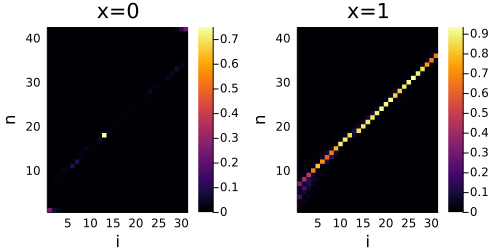

In [130]:
j=4
bel = bels_eps[1:N+2,:,:,j];
p0 = heatmap(bel[:,1,:], xlabel="i", ylabel="n", title="x=0")
p1 = heatmap(bel[:,2,:], xlabel="i", ylabel="n", title="x=1")
p = plot(p0, p1, size=(500,250))